In [1]:
# Imports from the helpers folder, containing the lstm code and auxilliary functions
import sys  
sys.path.insert(0, "helpers/")
from lstm import Model, Optimization
from aux_functions import (ts_train_test_split)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pltio
import statsmodels.api as sm
from datetime import datetime, timedelta
# Packages of forecasting models
from stldecompose import decompose, forecast
from statsmodels.tsa.statespace.sarimax import SARIMAX
from stldecompose.forecast_funcs import (drift)
import pmdarima as pm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load weekly sales data

In [91]:
# Milan data
milan_data_df = pd.read_csv("../datasets/ts_data/weekly_aug/aug_milan_cc_arese_data_w.csv", index_col=[0], parse_dates=True)
turin_data_df = pd.read_csv("../datasets/ts_data/weekly_aug/aug_turin_cc_torin_data_w.csv", index_col=[0], parse_dates=True)
rome_data_df = pd.read_csv("../datasets/ts_data/weekly_aug/aug_rome_neg_tusc2_data_w.csv", index_col=[0], parse_dates=True)

print("Shape (dim) of datasets:")
print("Milan:", milan_data_df.shape)
print("Turin:", turin_data_df.shape)
print("Rome:", rome_data_df.shape)

# Create dict containing datasets to make running experiments easier
datasets = {
    "Milan": milan_data_df,
    "Turin": turin_data_df, 
    "Rome": rome_data_df
}

Milan sales data
(194, 15)
(209, 15)
(209, 15)


# Data Visualization and Exploration 

Milan data 



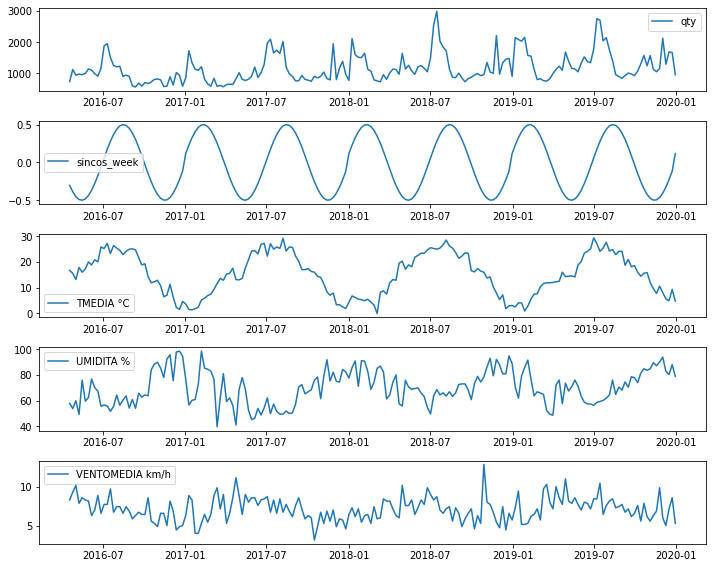

Turin data 



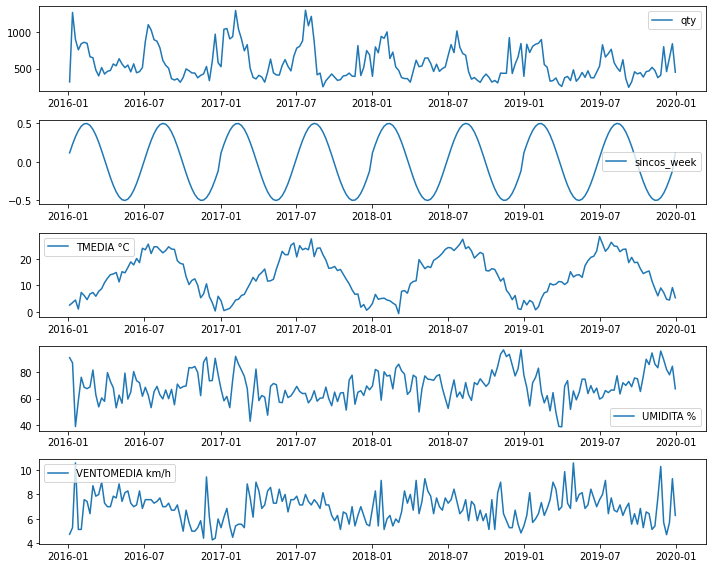

Rome data 



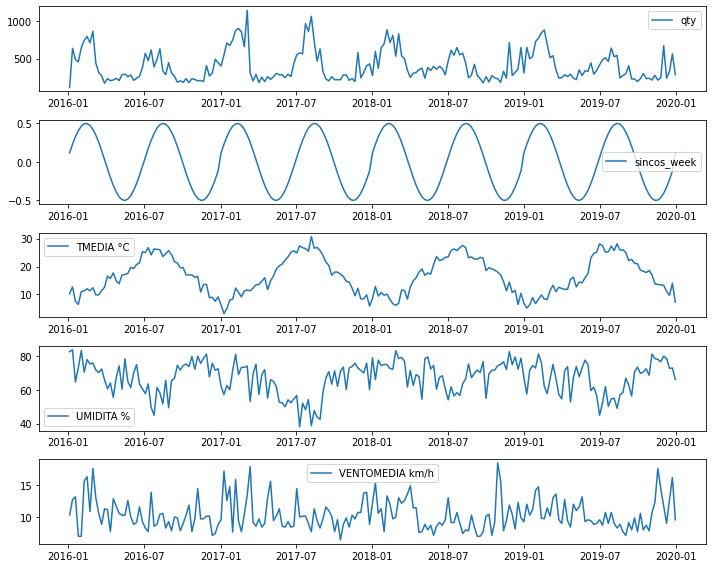

In [93]:
# Plot the data to explore and see what we are working with
# Here we can see what the features we will train the network on later look like
for dataset in datasets:
    print(dataset, "data \n")
    values = datasets[dataset].values
    cols_to_plot = [0,3,4,8,10]
    i=1
    plt.figure(figsize=(10,8))
    for col in cols_to_plot:
        plt.subplot(len(cols_to_plot), 1, i)
        plt.plot(datasets[dataset].iloc[:, col], label=datasets[dataset].columns[col])
        plt.legend()
        i += 1
    #plt.savefig("mono_exog_features_plot.png", transparent = True, bbox_inches = 'tight', pad_inches = 0)
    plt.tight_layout() 
    plt.show()

# LSTM helper functions

In [57]:
def build_in_out_seq(tr_df, te_df, desired_input_features, in_len, out_len):
    # Building the NN input and outputs. LSTM will expect a supervised learning problem, hence we need to build
    # input sequences that will have output sequences which the model will then learn.
    
    # Training
    inp_tr = np.stack([tr_df.shift(i).values for i in range(out_len, out_len+in_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    out_tr = np.stack([tr_df.shift(i).values for i in range(out_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    # Testing
    inp_te = np.stack([te_df.shift(i).values for i in range(out_len, out_len+in_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    out_te = np.stack([te_df.shift(i).values for i in range(out_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    print("Inputs for training")
    print(inp_tr.shape)
    print("Outputs for training")
    print(out_tr.shape)
    print("Inputs for testing")
    print(inp_te.shape)
    print("Outputs for testing")
    print(out_te.shape)
    print("\n")
    return inp_tr, out_tr, inp_te, out_te

def prepare_for_network(train, test, input_features, in_len, out_len):
    # Build the full training and testing dataframes
    # In order to pass the data to the LSTM we need to transform it so it is in the range [0,1]
    # We scale all our data in order to build the final training and test dataframes
    tr_df = train.copy(deep=True)
    te_df = test.copy(deep=True)
    
    for col in tr_df.columns:
        # Z standartization
        mean = np.mean(train.loc[:,col].values)
        std = np.std(train.loc[:,col].values)
        
        tr_df.loc[:, col] = (train.loc[:,col].values-mean)/std
        te_df.loc[:, col] = (test.loc[:,col].values-mean)/std

    # Prepare data for the LSTM Network: We need to create sequences of inputs and outputs
    # so that our time series problem esentially becomes a "supervised regression problem".
    inp_tr, out_tr, inp_te, out_te = build_in_out_seq(tr_df, pd.concat([tr_df.iloc[-in_len:, :], te_df]), input_features, in_len, out_len)
    return inp_tr, out_tr, inp_te, out_te

def define_LSTM_Model(input_features):#10+len(input_features)*6#
    loss_fn = nn.MSELoss()
    LSTM_Model = Model(input_size=len(input_features), hidden_size=256, output_size=len(input_features))
    optimizer = optim.Adam(LSTM_Model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=25, gamma=0.1)
    opt_obj = Optimization(LSTM_Model, loss_fn, optimizer, scheduler)
    return LSTM_Model, opt_obj

def check_lstm_forecast_results(pred, inp_te, out_te, poll_mean, poll_std, in_len, out_len):
    # *Data back needs to rescaled back to normal*
    pred_vec = (pred[0,-out_len:,0].detach().cpu().numpy() * poll_std) + poll_mean
    real_vec = (out_te[0,:,0] * poll_std) + poll_mean
    rmse = sm.tools.eval_measures.rmse(pred_vec, real_vec)
    mae = sm.tools.eval_measures.meanabs(pred_vec, real_vec)
    
    return rmse, mae

def build_lstm_full_preds(out_sq, pred_seq, out_len, mean, std):
    lstm_step_preds = []
    for i in range(0, out_sq.shape[0], out_len):
        lstm_step_preds.extend(((pred_seq[i,-out_len:,0].detach().cpu().numpy()*std)+mean))
          
    return lstm_step_preds

# Forecasting evaluation

In [99]:
single_run_results = []
n_runs = 1

for dataset in datasets:
    print("Running forecasting for sales in", dataset, "\n")
    for run in range(n_runs):
        print ("Run #", run+1)
        # Load the default and augmented versions of the data
        full_dataset = datasets[dataset]

        # Create training and test data
        train, test = ts_train_test_split(full_dataset, test_length=0.2)
        print("Training and testing data shapes: ", train.shape, test.shape)
      
        # Extract the columns which display most correlation with the value we are trying to predict.
        mono_input_features = [0]
        exo1_input_features = [0, 1, 2, 3]
        exo2_input_features = [0] + list(range(4,full_dataset.shape[1]))
        exo3_input_features = [0, 1, 2, 3, 4, 5, full_dataset.shape[1]-1] 
        #exo3_input_features = list(range(0,full_dataset.shape[1]))
        print("MONO-LSTM input features:", mono_input_features)
        print("EXO1 (+ sincos day) input features :", exo1_input_features)
        print("EXO2 (+ weather exog) input features :", exo2_input_features)
        print("EXO3 (+ all exog) input features :", exo3_input_features)
        print()
        
        ## Run STL Decomposition as baseline
        print("Running Drift and Seasonal Drift models based on STL Decomposition...")
        f_steps = test.shape[0]
        decomp = decompose(train.qty, period=52)
        drift_forecast = forecast(decomp, steps=f_steps, fc_func=drift, seasonal=True)
        drift_rmse = sm.tools.eval_measures.rmse(test.qty.values, drift_forecast["drift+seasonal"].values)
        drift_mae = sm.tools.eval_measures.meanabs(test.qty.values, drift_forecast["drift+seasonal"].values)
        print("Done\n")
        
        # Run ARIMA as another baseline
        print("Running SARIMA model...")        
        # Fit your model
        sarima_model = pm.auto_arima(train.qty, seasonal=True, m=52, suppress_warnings=True, max_order=None, \
                                    start_p=3, start_q=0, start_P=0, start_Q=0, \
                                    max_p=6, max_d=1, max_q=1, max_P=1, max_D=1, max_Q=1)
        # Get model params
        sarima_order = sarima_model.get_params()["order"]
        sarima_s_order = sarima_model.get_params()["seasonal_order"]
        # Predict #test steps into the future
        sarima_forecasts = sarima_model.predict(f_steps)  
        sarima_rmse = sm.tools.eval_measures.rmse(test.qty.values, sarima_forecasts)
        sarima_mae = sm.tools.eval_measures.meanabs(test.qty.values, sarima_forecasts)
        print("Done\n")
        
        print("Running SARIMAX model...")
        sarimax_model = SARIMAX(endog=train.qty, exog=train.iloc[:, exo3_input_features[1:]], \
                                order=sarima_order, seasonal_order=sarima_s_order)
        sarimax_fitted = sarimax_model.fit()
        sarimax_forecasts = sarimax_fitted.forecast(f_steps, exog=test.iloc[:, exo3_input_features[1:]])  
        sarimax_rmse = sm.tools.eval_measures.rmse(test.qty.values, sarimax_forecasts)
        sarimax_mae = sm.tools.eval_measures.meanabs(test.qty.values, sarimax_forecasts)
        print("Done\n")
        
        ## LSTM
        # Define the LSTM Models and their Optimizer objects
        mono_LSTM_Model, mono_opt_obj = define_LSTM_Model(mono_input_features)
        exo1_LSTM_Model, exo1_opt_obj = define_LSTM_Model(exo1_input_features)
        exo2_LSTM_Model, exo2_opt_obj = define_LSTM_Model(exo2_input_features)
        exo3_LSTM_Model, exo3_opt_obj = define_LSTM_Model(exo3_input_features)

        # 1) MONO-LSTM data
        mono_inp_tr, mono_out_tr, mono_inp_te, mono_out_te = prepare_for_network(train, test, mono_input_features, in_len=54+f_steps, out_len=f_steps)
        mono_x_train=torch.cat((torch.Tensor(mono_inp_tr),torch.Tensor(mono_out_tr)),1)
        mono_x_test=torch.Tensor(mono_inp_te)

        # 2) EXO1-LSTM data
        exo1_inp_tr, exo1_out_tr, exo1_inp_te, exo1_out_te = prepare_for_network(train, test, exo1_input_features, in_len=54+f_steps, out_len=f_steps)
        exo1_x_train=torch.cat((torch.Tensor(exo1_inp_tr),torch.Tensor(exo1_out_tr)),1)
        exo1_x_test=torch.Tensor(exo1_inp_te)

        # 3) EXO2-LSTM data
        exo2_inp_tr, exo2_out_tr, exo2_inp_te, exo2_out_te = prepare_for_network(train, test, exo2_input_features, in_len=54+f_steps, out_len=f_steps)
        exo2_x_train=torch.cat((torch.Tensor(exo2_inp_tr),torch.Tensor(exo2_out_tr)),1)
        exo2_x_test=torch.Tensor(exo2_inp_te)

        # 4) EXO3-LSTM data
        exo3_inp_tr, exo3_out_tr, exo3_inp_te, exo3_out_te = prepare_for_network(train, test, exo3_input_features, in_len=54+f_steps, out_len=f_steps)
        exo3_x_train=torch.cat((torch.Tensor(exo3_inp_tr),torch.Tensor(exo3_out_tr)),1)
        exo3_x_test=torch.Tensor(exo3_inp_te)

        # Train all the LSTMs 
        print("Training the MONO-LSTM model...")
        mono_opt_obj.train(mono_x_train[:,:-1],mono_x_train[:,1:],mono_x_train[:,:-1],mono_x_train[:,1:], \
                           do_teacher_forcing=True, n_epochs=20, batch_size=1)
        print("Done\n")
        print("Training the EXO1-LSTM model...")
        exo1_opt_obj.train(exo1_x_train[:,:-1],exo1_x_train[:,1:],exo1_x_train[:,:-1],exo1_x_train[:,1:], \
                           do_teacher_forcing=True, n_epochs=20, batch_size=1)
        print("Done\n")
        print("Training the EXO2-LSTM model...")
        exo2_opt_obj.train(exo2_x_train[:,:-1],exo2_x_train[:,1:],exo2_x_train[:,:-1],exo2_x_train[:,1:], \
                           do_teacher_forcing=True, n_epochs=20, batch_size=1)
        print("Done\n")
        print("Training the EXO3-LSTM model...")
        exo3_opt_obj.train(exo3_x_train[:,:-1],exo3_x_train[:,1:],exo3_x_train[:,:-1],exo3_x_train[:,1:], \
                           do_teacher_forcing=True, n_epochs=20, batch_size=1)
        print("Done\n")

        # Make predictions using the trained networks
        mono_pred = mono_LSTM_Model(mono_x_test, f_steps)
        exo1_pred = exo1_LSTM_Model(exo1_x_test, f_steps)
        exo2_pred = exo2_LSTM_Model(exo2_x_test, f_steps)
        exo3_pred = exo3_LSTM_Model(exo3_x_test, f_steps)

        ## Check results of LSTM forecasts (calc erros)
        mean = np.mean(train.qty.values)
        std = np.std(train.qty.values)
        mono_lstm_rmse, mono_lstm_mae = check_lstm_forecast_results(mono_pred, mono_inp_te, mono_out_te, mean, std, in_len=54+f_steps, out_len=f_steps)
        exo1_lstm_rmse, exo1_lstm_mae = check_lstm_forecast_results(exo1_pred, exo1_inp_te, exo1_out_te, mean, std, in_len=54+f_steps, out_len=f_steps)
        exo2_lstm_rmse, exo2_lstm_mae = check_lstm_forecast_results(exo2_pred, exo2_inp_te, exo2_out_te, mean, std, in_len=54+f_steps, out_len=f_steps)
        exo3_lstm_rmse, exo3_lstm_mae = check_lstm_forecast_results(exo3_pred, exo3_inp_te, exo3_out_te, mean, std, in_len=54+f_steps, out_len=f_steps)

        fig = go.Figure()
        x_labels = list(range(0,f_steps))
        fig.add_trace(go.Scatter(x=x_labels, y=test.qty,
                    mode='lines', name='GT'))
        fig.add_trace(go.Scatter(x=x_labels, y=drift_forecast["drift+seasonal"].values,
                    mode='lines', name='SDRIFT'))
        fig.add_trace(go.Scatter(x=x_labels, y=sarima_forecasts,
                    mode='lines', name='SARIMA'+str(sarima_order)))
        fig.add_trace(go.Scatter(x=x_labels, y=sarimax_forecasts,
                    mode='lines', name='SARIMAX'+str(sarima_order)))
        fig.add_trace(go.Scatter(x=x_labels, y=(mono_pred[0,-f_steps:,0].detach().cpu().numpy()*std)+mean,
                     mode='lines', name='MONO-LSTM'))
        fig.add_trace(go.Scatter(x=x_labels, y=(exo1_pred[0,-f_steps:,0].detach().cpu().numpy()*std)+mean,
                     mode='lines', name='EXO1-LSTM'))
        fig.add_trace(go.Scatter(x=x_labels, y=(exo2_pred[0,-f_steps:,0].detach().cpu().numpy()*std)+mean,
                     mode='lines', name='EXO2-LSTM'))
        fig.add_trace(go.Scatter(x=x_labels, y=(exo3_pred[0,-f_steps:,0].detach().cpu().numpy()*std)+mean,
                     mode='lines', name='EXO3-LSTM'))
        #Update plot title and axis titles, then save plot as a HTML File
        fig.update_layout(
            title="Forecast of test set",
            xaxis_title="Time steps",
            yaxis_title="Prediction",
            font=dict(
                family="Courier New, monospace",
                size=16,
                color="#7f7f7f"
            )
        )
        fig.show()
        #pltio.write_html(fig, dataset+"-"+"run"+str(run+1)+"weekly-sales-results.html")
 
        single_run_results.append([dataset, "run "+str(run+1), drift_rmse, sarima_rmse, sarimax_rmse,\
                                   mono_lstm_rmse, exo1_lstm_rmse, exo2_lstm_rmse, exo3_lstm_rmse, \
                                   drift_mae, sarima_mae, sarimax_mae, \
                                   mono_lstm_mae, exo1_lstm_mae, exo2_lstm_mae, exo3_lstm_mae])
    
        print()

Running forecasting for sales in Milan 

Run # 1
Training and testing data shapes:  (156, 15) (38, 15)
MONO-LSTM input features: [0]
EXO1 (+ sincos day) input features : [0, 1, 2, 3]
EXO2 (+ weather exog) input features : [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
EXO3 (+ all exog) input features : [0, 1, 2, 3, 4, 5, 14]

Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (0, 0, 1)x(0, 1, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (1, 0, 0)x(0, 1, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (1, 0, 0)x(1, 1, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")



Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency W-MON will be used.



Done

Inputs for training
(27, 92, 1)
Outputs for training
(27, 38, 1)
Inputs for testing
(1, 92, 1)
Outputs for testing
(1, 38, 1)


Inputs for training
(27, 92, 4)
Outputs for training
(27, 38, 4)
Inputs for testing
(1, 92, 4)
Outputs for testing
(1, 38, 4)


Inputs for training
(27, 92, 12)
Outputs for training
(27, 38, 12)
Inputs for testing
(1, 92, 12)
Outputs for testing
(1, 38, 12)


Inputs for training
(27, 92, 7)
Outputs for training
(27, 38, 7)
Inputs for testing
(1, 92, 7)
Outputs for testing
(1, 38, 7)


Training the MONO-LSTM model...
Epoch 1 Train loss: 0.85. Validation loss: 0.79. Avg future: 28.96. Elapsed time: 4.27s.
Epoch 2 Train loss: 0.72. Validation loss: 0.63. Avg future: 32.96. Elapsed time: 4.91s.
Epoch 3 Train loss: 0.58. Validation loss: 0.58. Avg future: 31.85. Elapsed time: 4.59s.
Epoch 4 Train loss: 0.55. Validation loss: 0.57. Avg future: 30.04. Elapsed time: 4.04s.
Epoch 5 Train loss: 0.64. Validation loss: 0.69. Avg future: 38.77. Elapsed time: 4.03s.
E


Running forecasting for sales in Turin 

Run # 1
Training and testing data shapes:  (168, 15) (41, 15)
MONO-LSTM input features: [0]
EXO1 (+ sincos day) input features : [0, 1, 2, 3]
EXO2 (+ weather exog) input features : [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
EXO3 (+ all exog) input features : [0, 1, 2, 3, 4, 5, 14]

Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...
Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency W-MON will be used.

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Inputs for training
(33, 95, 1)
Outputs for training
(33, 41, 1)
Inputs for testing
(1, 95, 1)
Outputs for testing
(1, 41, 1)


Inputs for training
(33, 95, 4)
Outputs for training
(33, 41, 4)
Inputs for testing
(1, 95, 4)
Outputs for testing
(1, 41, 4)


Inputs for training
(33, 95, 12)
Outputs for training
(33, 41, 12)
Inputs for testing
(1, 95, 12)
Outputs for testing
(1, 41, 12)


Inputs for training
(33, 95, 7)
Outputs for training
(33, 41, 7)
Inputs for testing
(1, 95, 7)
Outputs for testing
(1, 41, 7)


Training the MONO-LSTM model...
Epoch 1 Train loss: 0.72. Validation loss: 0.47. Avg future: 31.12. Elapsed time: 5.08s.
Epoch 2 Train loss: 0.40. Validation loss: 0.41. Avg future: 32.47. Elapsed time: 5.00s.
Epoch 3 Train loss: 0.36. Validation loss: 0.36. Avg future: 32.62. Elapsed time: 5.08s.
Epoch 4 Train loss: 0.35. Validation loss: 0.35. Avg future: 32.91. Elapsed time: 5.04s.
Epoch 5 Train loss: 0.33. Validation loss: 0.36. Avg future: 31.34. Elapsed time: 5.01s.
E


Running forecasting for sales in Rome 

Run # 1
Training and testing data shapes:  (168, 15) (41, 15)
MONO-LSTM input features: [0]
EXO1 (+ sincos day) input features : [0, 1, 2, 3]
EXO2 (+ weather exog) input features : [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
EXO3 (+ all exog) input features : [0, 1, 2, 3, 4, 5, 14]

Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...
Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency W-MON will be used.



Done

Inputs for training
(33, 95, 1)
Outputs for training
(33, 41, 1)
Inputs for testing
(1, 95, 1)
Outputs for testing
(1, 41, 1)


Inputs for training
(33, 95, 4)
Outputs for training
(33, 41, 4)
Inputs for testing
(1, 95, 4)
Outputs for testing
(1, 41, 4)


Inputs for training
(33, 95, 12)
Outputs for training
(33, 41, 12)
Inputs for testing
(1, 95, 12)
Outputs for testing
(1, 41, 12)


Inputs for training
(33, 95, 7)
Outputs for training
(33, 41, 7)
Inputs for testing
(1, 95, 7)
Outputs for testing
(1, 41, 7)


Training the MONO-LSTM model...
Epoch 1 Train loss: 0.68. Validation loss: 0.48. Avg future: 30.41. Elapsed time: 5.51s.
Epoch 2 Train loss: 0.40. Validation loss: 0.36. Avg future: 31.69. Elapsed time: 5.76s.
Epoch 3 Train loss: 0.36. Validation loss: 0.37. Avg future: 31.84. Elapsed time: 5.13s.
Epoch 4 Train loss: 0.34. Validation loss: 0.33. Avg future: 35.47. Elapsed time: 5.35s.
Epoch 5 Train loss: 0.33. Validation loss: 0.33. Avg future: 31.34. Elapsed time: 5.05s.
E

In [100]:
# Results for each run of forecasting
single_run_results_df = pd.DataFrame(single_run_results, 
                                     columns= ["Dataset", "Run Nr.", "DRIFT RMSE", "SARIMA RMSE", "SARIMAX RMSE",\
                                              "MONO-LSTM RMSE", "EXO1-LSTM RMSE", "EXO2-LSTM RMSE", "EXO3-LSTM RMSE",\
                                              "DRIFT MAE", "SARIMA MAE", "SARIMAX MAE",\
                                              "MONO-LSTM MAE", "EXO1-LSTM MAE", "EXO2-LSTM MAE", "EXO3-LSTM MAE"])
single_run_results_df

,Dataset,Run Nr.,DRIFT RMSE,SARIMA RMSE,SARIMAX RMSE,MONO-LSTM RMSE,EXO1-LSTM RMSE,EXO2-LSTM RMSE,EXO3-LSTM RMSE,DRIFT MAE,SARIMA MAE,SARIMAX MAE,MONO-LSTM MAE,EXO1-LSTM MAE,EXO2-LSTM MAE,EXO3-LSTM MAE
0,Milan,run 1,388.944542,299.299334,320.984901,340.646023,285.277540,457.139046,266.136811,296.617978,176.304175,216.735183,244.106005,218.532238,366.911925,208.688844
1,Turin,run 1,148.956393,138.097168,147.847407,175.310769,137.844724,292.181866,142.659607,117.761828,110.590440,108.999305,144.411340,118.281231,222.548635,122.477066
2,Rome,run 1,166.804684,107.927471,103.974566,124.368470,96.410477,170.794389,116.796118,140.935231,87.314170,79.757936,87.475510,61.039893,134.558907,88.743503


In [101]:
# Aggregate results
mean_results = single_run_results_df.copy(deep=True)
mean_results = mean_results.groupby(["Dataset"]).agg(np.mean)
mean_results

,DRIFT RMSE,SARIMA RMSE,SARIMAX RMSE,MONO-LSTM RMSE,EXO1-LSTM RMSE,EXO2-LSTM RMSE,EXO3-LSTM RMSE,DRIFT MAE,SARIMA MAE,SARIMAX MAE,MONO-LSTM MAE,EXO1-LSTM MAE,EXO2-LSTM MAE,EXO3-LSTM MAE
Dataset,,,,,,,,,,,,,,
Milan,388.944542,299.299334,320.984901,340.646023,285.277540,457.139046,266.136811,296.617978,176.304175,216.735183,244.106005,218.532238,366.911925,208.688844
Rome,166.804684,107.927471,103.974566,124.368470,96.410477,170.794389,116.796118,140.935231,87.314170,79.757936,87.475510,61.039893,134.558907,88.743503
Turin,148.956393,138.097168,147.847407,175.310769,137.844724,292.181866,142.659607,117.761828,110.590440,108.999305,144.411340,118.281231,222.548635,122.477066


In [102]:
mean_results.mean()

DRIFT RMSE        234.901873
SARIMA RMSE       181.774658
SARIMAX RMSE      190.935624
MONO-LSTM RMSE    213.441754
EXO1-LSTM RMSE    173.177580
EXO2-LSTM RMSE    306.705101
EXO3-LSTM RMSE    175.197512
DRIFT MAE         185.105012
SARIMA MAE        124.736262
SARIMAX MAE       135.164141
MONO-LSTM MAE     158.664285
EXO1-LSTM MAE     132.617787
EXO2-LSTM MAE     241.339822
EXO3-LSTM MAE     139.969805
dtype: float64